In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
credit = pd.read_csv("../data/creditcard.csv")

# Features and target
X_credit = credit.drop('Class', axis=1)
y_credit = credit['Class']

# Scale 'Amount' and 'Time'
scaler = StandardScaler()
X_credit[['Time', 'Amount']] = scaler.fit_transform(X_credit[['Time', 'Amount']])

# Train-test split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_credit, y_credit, test_size=0.3, random_state=42, stratify=y_credit)


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

fraud = pd.read_csv("../data/Fraud_Data.csv")

# Convert datetime to numeric
for dt_col in ['signup_time', 'purchase_time']:
    fraud[dt_col] = pd.to_datetime(fraud[dt_col], errors='coerce').astype('int64') // 10**9

# Encode categorical columns
categorical_cols = ['device_id', 'source', 'browser', 'sex']

# Check if any categorical column is missing from your dataset
categorical_cols = [col for col in categorical_cols if col in fraud.columns]

for col in categorical_cols:
    fraud[col], _ = pd.factorize(fraud[col])

# Verify no object columns remain
print("Object columns after encoding:", fraud.select_dtypes(include=['object']).columns)

# Now split features and target
X_fraud = fraud.drop('class', axis=1)
y_fraud = fraud['class']

# Drop any rows with NaN (in case datetime conversion caused missing values)
X_fraud = X_fraud.dropna()
y_fraud = y_fraud[X_fraud.index]

# Apply SMOTE
smote = SMOTE(random_state=42)
Xf_resampled, yf_resampled = smote.fit_resample(X_fraud, y_fraud)

# Train-test split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf_resampled, yf_resampled, test_size=0.3, random_state=42
)


Object columns after encoding: Index([], dtype='object')


In [5]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"\n--- {name} ---")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-PR:", average_precision_score(y_test, y_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



--- Logistic Regression - CreditCard ---
F1 Score: 0.12452107279693486
AUC-PR: 0.7041384932453245

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



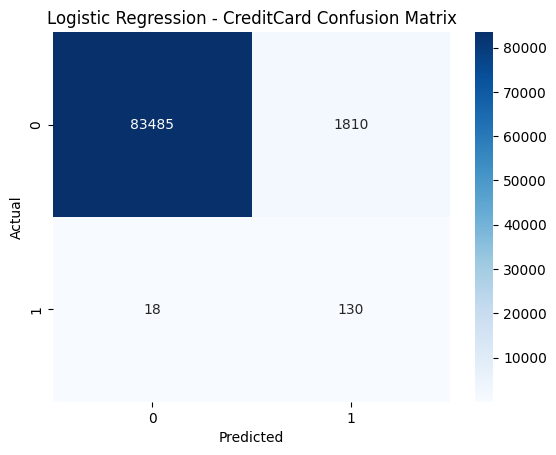

c:\Users\rebika\Desktop\fraud-detection-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost - CreditCard ---
F1 Score: 0.8389513108614233
AUC-PR: 0.7861327560013495

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.76      0.84       148

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



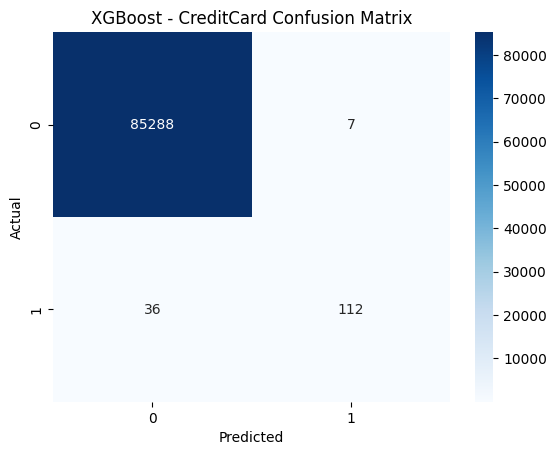

In [6]:
logit_credit = LogisticRegression(max_iter=1000, class_weight='balanced')
xgb_credit = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

evaluate_model("Logistic Regression - CreditCard", logit_credit, Xc_train, yc_train, Xc_test, yc_test)
evaluate_model("XGBoost - CreditCard", xgb_credit, Xc_train, yc_train, Xc_test, yc_test)



--- Logistic Regression - Fraud_Data ---
F1 Score: 0.6967957259741715
AUC-PR: 0.83800877529512

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71     40965
           1       0.72      0.68      0.70     41212

    accuracy                           0.70     82177
   macro avg       0.70      0.70      0.70     82177
weighted avg       0.70      0.70      0.70     82177



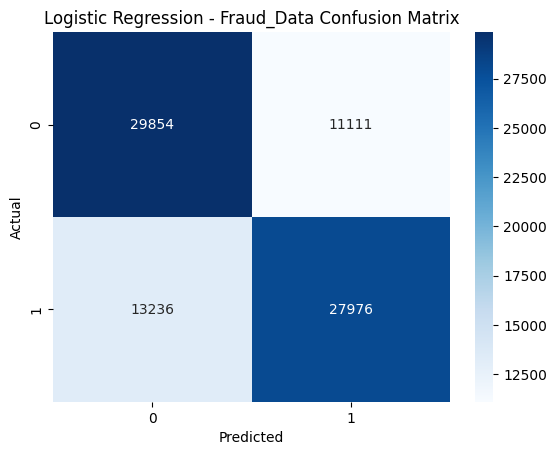

c:\Users\rebika\Desktop\fraud-detection-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost - Fraud_Data ---
F1 Score: 0.8300049957088143
AUC-PR: 0.9370006316932054

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     40965
           1       0.88      0.79      0.83     41212

    accuracy                           0.84     82177
   macro avg       0.84      0.84      0.84     82177
weighted avg       0.84      0.84      0.84     82177



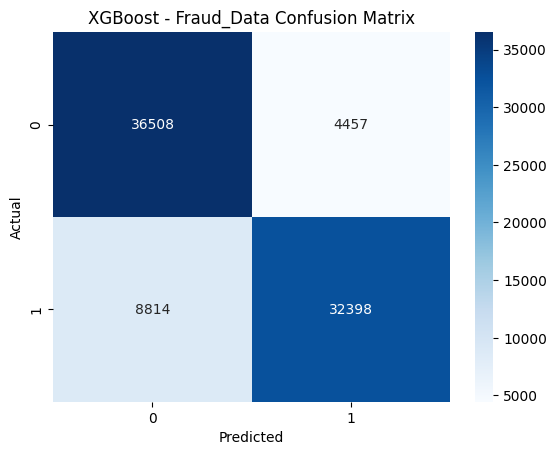

In [7]:
logit_fraud = LogisticRegression(max_iter=1000, class_weight='balanced')
xgb_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

evaluate_model("Logistic Regression - Fraud_Data", logit_fraud, Xf_train, yf_train, Xf_test, yf_test)
evaluate_model("XGBoost - Fraud_Data", xgb_fraud, Xf_train, yf_train, Xf_test, yf_test)
